### Import libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score

### Load the Data

In [2]:
# Load CSV files
df_signnames = pd.read_csv('data/signnames.csv')
df_train = pd.read_csv('data/Train.csv')
df_test = pd.read_csv('data/Test.csv')

In [3]:
# Assign Images path
img_dir = 'data/'
train_dir = 'data/Train'
test_dir = 'data/Test'
train_img_path = img_dir + df_train["Path"].values
test_img_path = df_test["Path"].values

In [4]:
# Number of Classes
classes = df_train["ClassId"].nunique()

In [5]:
# Define Classes Names
signnames = df_signnames['SignName']

### Data Exploration

In [6]:
df_signnames.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [7]:
df_train.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [8]:
df_test.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [9]:
print("The Number of Classes is: ", classes)

The Number of Classes is:  43


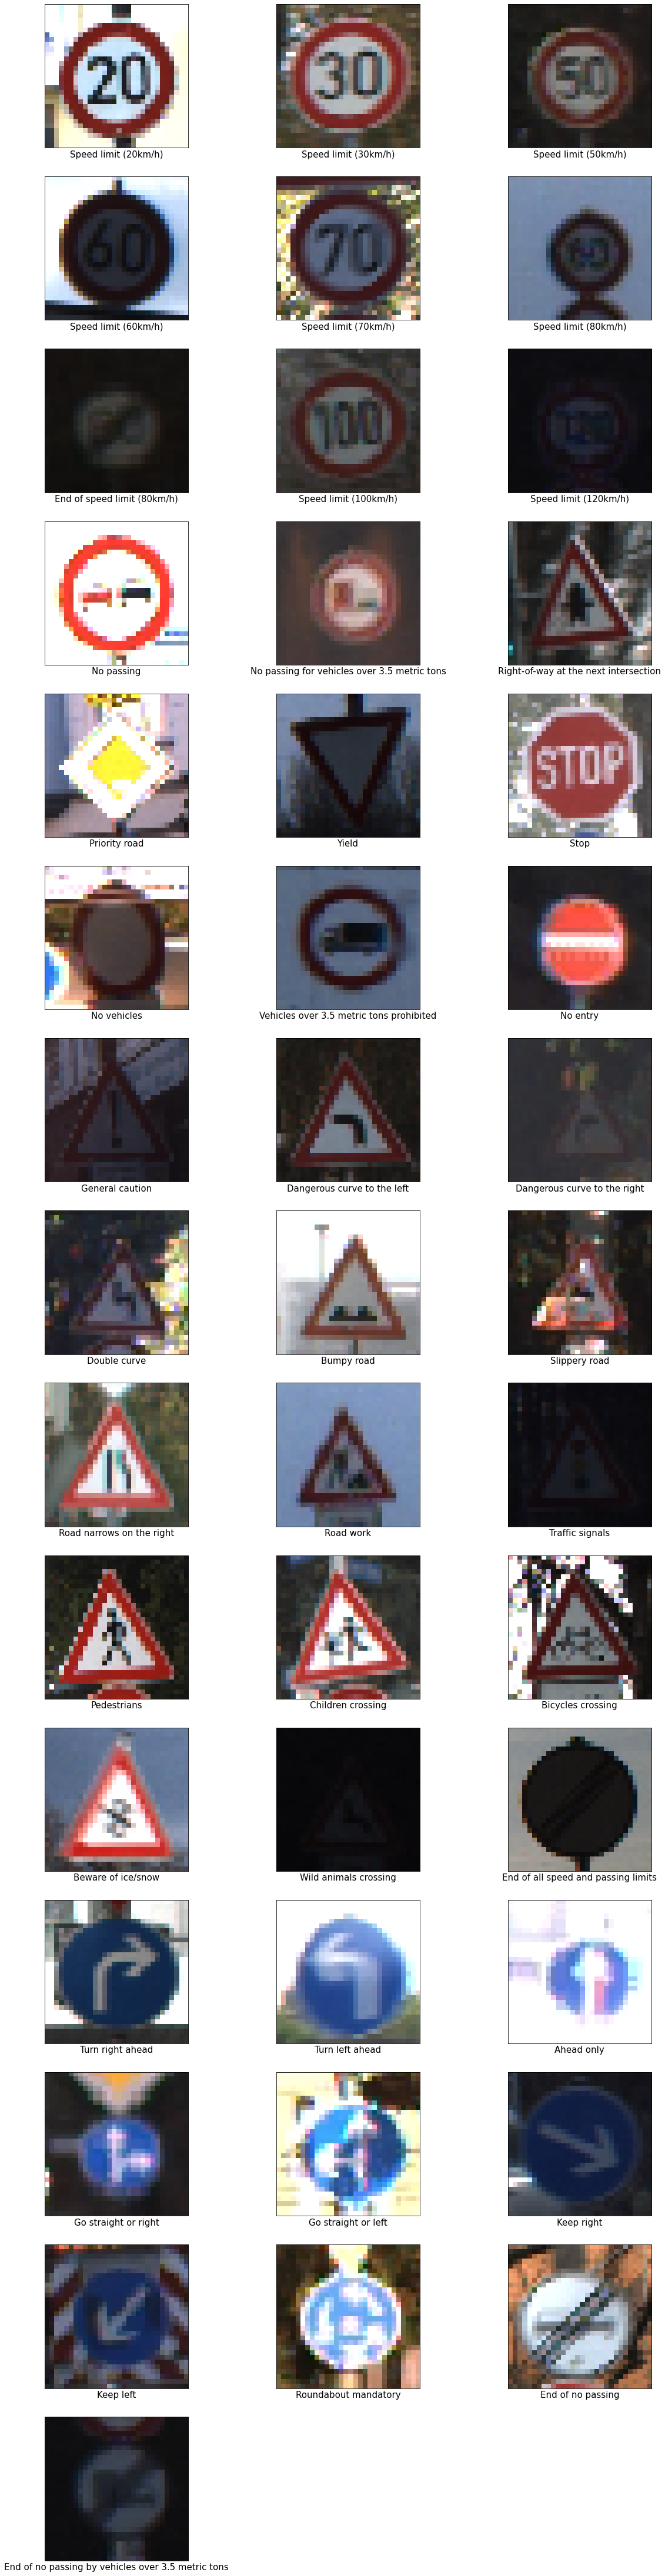

In [10]:
# Visualizing all Signs
train_img_dir = pathlib.Path(train_dir)
plt.figure(figsize=(20,80))
index = 0
for i in range(classes):
    plt.subplot(15, 3, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    sign = list(train_img_dir.glob(f'{i}/*'))[0]
    img = load_img(sign, target_size=(30, 30))
    labels = signnames[i]
    plt.xlabel(labels, fontsize = 15)
    plt.imshow(img)
plt.show()

### Ploting a Histogram to show the number of images in each class

In [11]:
def hist_plot(path, signnames):
    """a function that will plot a Histogram to show the number of images in each class"""
    folders = os.listdir(path)
    train_number = []
    class_num = []
    plt.figure(figsize=(21,9))
    for folder in folders:
        train_files = os.listdir(path + '/' + folder)
        train_number.append(len(train_files))
        class_num.append(signnames[int(folder)])
    zipped_lists = zip(train_number, class_num)
    sorted_pairs = sorted(zipped_lists)
    tuples = zip(*sorted_pairs)
    train_number, class_num = [ list(tuple) for tuple in  tuples]
    plt.bar(class_num, train_number)
    plt.title("Image count in each class")
    plt.ylabel("Counts")
    plt.xlabel("Classes")
    plt.xticks(class_num, rotation='vertical')
    plt.show()

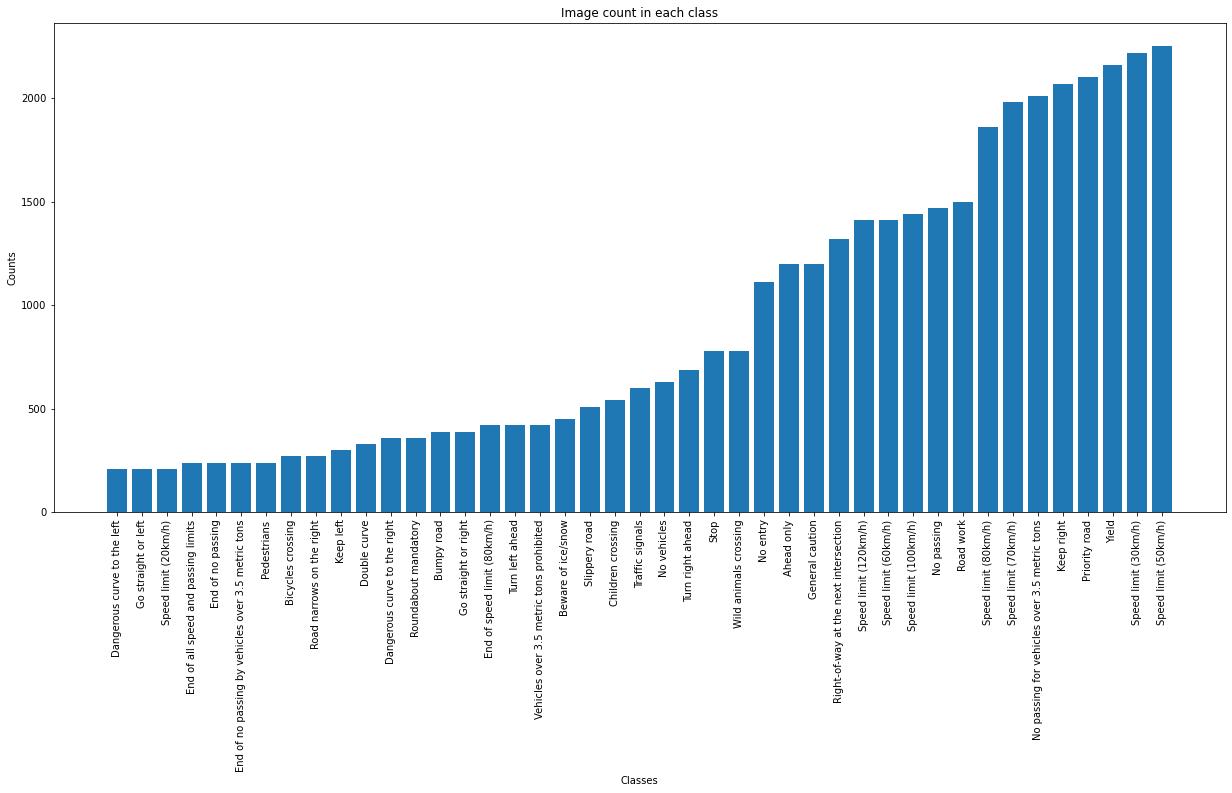

In [12]:
hist_plot(train_dir, signnames)

### Data Processing

In [13]:
def image_to_array(img_path, df):
    """a function that will read the images and convert them to array"""
    image_data = []
    image_labels = df.ClassId
    for i in range(len(img_path)):
        image = tf.io.read_file(img_path[i])
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.cast(image, tf.float32)/256.0
        image = tf.image.resize(image, [30, 30])
        image_data.append(image)
    # changing the list to a numpy array
    image_data = np.array(image_data)
    image_labels = np.array(image_labels)
    return image_data, image_labels

In [14]:
#image_data, image_labels = image_to_array(train_img_path, df_train)

In [15]:
# To Save Images Array Data
#np.save('data/image_data', image_data)
#np.save('data/image_labels', image_labels)

In [16]:
# To Import Images Array Data
image_data = np.load('data/image_data.npy')
image_labels = np.load('data/image_labels.npy')

In [17]:
image_data.shape

(39209, 30, 30, 3)

In [18]:
image_labels.shape

(39209,)

In [19]:
# One hot encoding the labels
image_labels = to_categorical(image_labels)

In [20]:
image_labels.shape

(39209, 43)

### Traind Test Split

In [21]:
# Splitting the dataset into training and validation
x_train, x_val, y_train, y_val = train_test_split(np.array(image_data), image_labels, test_size=0.4)

In [22]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((23525, 30, 30, 3), (15684, 30, 30, 3), (23525, 43), (15684, 43))

### Define the Model

In [23]:
def create_model():
    """ a function that will create a convolutional neural network model """
    model = Sequential([
        # Input Layer
        Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(30,30,3)),
        MaxPooling2D(pool_size=(2,2)),


        Conv2D(64, kernel_size=3, activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(.3),

        Conv2D(128, kernel_size=3, activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(.4),

        # Flattening the layer and adding Dense Layer
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(.5),
        # Output Layer
        Dense(43, activation='softmax'),
    ])
    # Compiling the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [24]:
# Clear session before we create the model
clear_session()

In [25]:
# Create a basic model instance
model = create_model()

In [26]:
# Display the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 128)         0

In [27]:
# Adding EarlyStopping
#callback = EarlyStopping(monitor='val_loss', patience=3)

In [28]:
# Fitting the model
#history = model.fit(x_train, y_train, epochs=100, batch_size=64, callbacks=[callback], validation_data = (x_val, y_val))
# Fitting the model
history = model.fit(x_train, y_train, epochs=30, batch_size=64, validation_data = (x_val, y_val))

Epoch 1/30
368/368 [==============================] - 12s 32ms/step - loss: 3.3141 - accuracy: 0.1184 - val_loss: 1.6034 - val_accuracy: 0.5061
Epoch 2/30
368/368 [==============================] - 11s 31ms/step - loss: 1.6587 - accuracy: 0.4665 - val_loss: 0.7565 - val_accuracy: 0.7634
Epoch 3/30
368/368 [==============================] - 11s 31ms/step - loss: 0.9729 - accuracy: 0.6789 - val_loss: 0.3857 - val_accuracy: 0.9020
Epoch 4/30
368/368 [==============================] - 11s 30ms/step - loss: 0.6063 - accuracy: 0.7975 - val_loss: 0.2270 - val_accuracy: 0.9439
Epoch 5/30
368/368 [==============================] - 11s 30ms/step - loss: 0.4658 - accuracy: 0.8478 - val_loss: 0.1364 - val_accuracy: 0.9696
Epoch 6/30
368/368 [==============================] - 12s 32ms/step - loss: 0.3579 - accuracy: 0.8814 - val_loss: 0.1170 - val_accuracy: 0.9694
Epoch 7/30
368/368 [==============================] - 11s 31ms/step - loss: 0.2976 - accuracy: 0.9019 - val_loss: 0.0830 - val_accuracy:

### Visualize training results

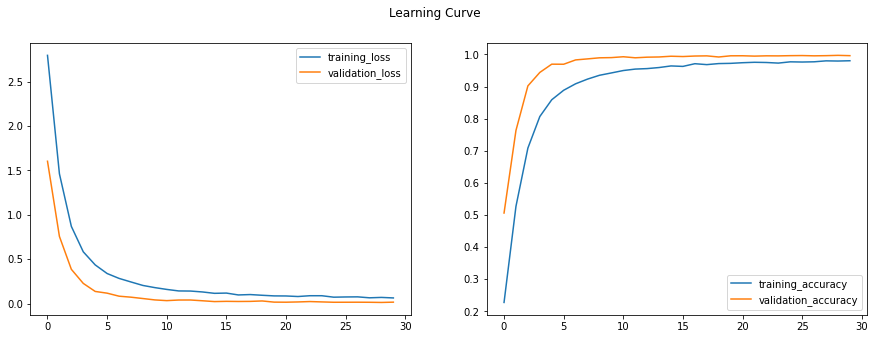

In [29]:
# Plot the learning curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Learning Curve')

ax1.plot(history.history['loss'], label='training_loss')
ax1.plot(history.history['val_loss'], label='validation_loss')
ax1.legend()

ax2.plot(history.history['accuracy'], label='training_accuracy')
ax2.plot(history.history['val_accuracy'], label='validation_accuracy')
ax2.legend()

### Evaluate the Model

In [30]:
# Evaluate the Model with the Train data
score = model.evaluate(x_train, y_train)
print("\n The Model Train Evaluation Score Is:" + str(score))

736/736 [==============================] - 3s 4ms/step - loss: 0.0043 - accuracy: 0.9995

 The Model Train Evaluation Score Is:[0.00430180924013257, 0.9994899034500122]


In [31]:
# Evaluate the Model with the Validation data
score_val = model.evaluate(x_val, y_val)
print("\n The Model Validation Evaluation Score Is:" + str(score_val))

491/491 [==============================] - 2s 5ms/step - loss: 0.0156 - accuracy: 0.9961

 The Model Validation Evaluation Score Is:[0.015633439645171165, 0.9961106777191162]


### Testing the Model using the Test Set

In [32]:
test_labels = df_test["ClassId"].values
output = list()
for img in test_img_path:
    image = load_img(os.path.join(img_dir, img), target_size=(30, 30))
    output.append(np.array(image))

X_test=np.array(output)
pred = model.predict_classes(X_test)

/home/wail/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [33]:
#Accuracy with the test data
print('Test accuracy: ', round(accuracy_score(test_labels, pred)*100, 2))

Test accuracy:  92.47


### Visualize Predictions

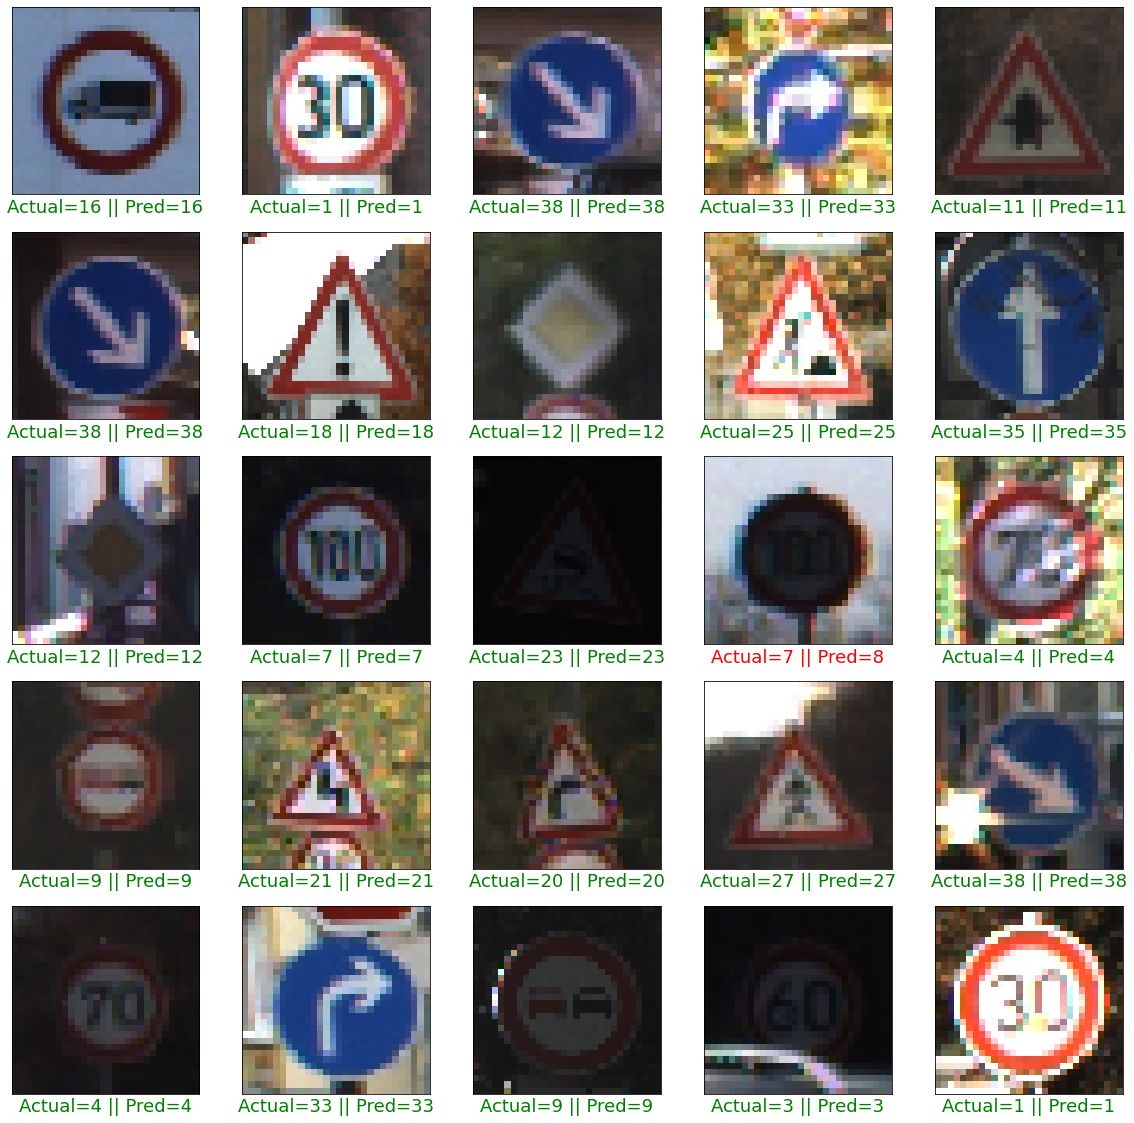

In [34]:
plt.figure(figsize = (20, 20))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = test_labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'. format(actual, prediction), color = col, fontsize = 18)
    plt.imshow(X_test[start_index + i])
plt.show()

### Testing the Model on New Images

In [64]:
# Define Image Path
img = load_img('data/test_images/12.png', target_size=(30, 30))

In [65]:
# Image to Array
img_array = img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
# Predict the imag
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

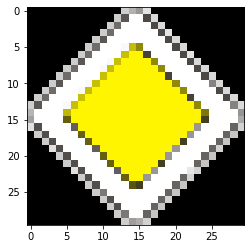

In [66]:
# Show the Image
plt.imshow(img)

In [67]:
print(
    "This image most likely belongs to '{}' sign..."
    .format(signnames[np.argmax(score)])
)

This image most likely belongs to 'Priority road' sign...


In [69]:
# Safe Model
model.save('saved_models/model_sign.h5')